In [46]:
import os
import numpy as np
import cv2
import warnings
import pickle
import pandas as pd
# import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.io import imread, imshow
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from skimage.color import rgb2hsv, rgb2gray
from scipy.signal import convolve2d
from skimage.morphology import (area_closing, area_opening, closing, opening,
                                dilation, erosion)
from Image_Pointer import Image_Pointer
from skimage import feature, filters
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from rubik.cube import Cube
from rubik.solve import Solver

# from keras.layers import (Dense, Dropout,
#                           Activation, add)
# from keras.models import Model, Input, Sequential, load_model
# from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
#                              EarlyStopping, ReduceLROnPlateau)
# from keras.utils.np_utils import to_categorical

%matplotlib inline

In [ ]:
# gpu = len(tf.config.list_physical_devices('GPU'))>0
# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
# print("GPU is", "available" if gpu else "NOT AVAILABLE")   

# Constant Variables

## Rubik 1

In [2]:
top_path1 = 'top.jpg'
bot_path1 = 'bottom.jpg'
front_path1 = 'front.jpg'
back_path1 = 'back.jpg'
left_path1 = 'left.jpg'
right_path1 = 'right.jpg'
top1  = imread(top_path1)
bot1  = imread(bot_path1)
front1 = imread(front_path1)
back1  = imread(back_path1)
left1  = imread(left_path1)
right1 = imread(right_path1)

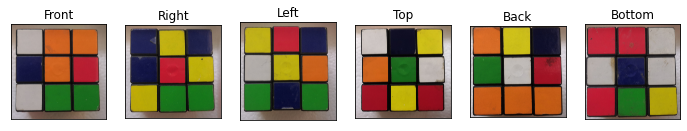

In [3]:
fig, ax = plt.subplots(1, 6, figsize=(12, 5))

ax[0].imshow(front1)
ax[0].set_title('Front'), ax[0].set_xticks([]), ax[0].set_yticks([])
ax[1].imshow(right1)
ax[1].set_title('Right'), ax[1].set_xticks([]), ax[1].set_yticks([])
ax[2].imshow(left1)
ax[2].set_title('Left'), ax[2].set_xticks([]), ax[2].set_yticks([])
ax[3].imshow(top1)
ax[3].set_title('Top'), ax[3].set_xticks([]), ax[3].set_yticks([])
ax[4].imshow(back1)
ax[4].set_title('Back'), ax[4].set_xticks([]), ax[4].set_yticks([])
ax[5].imshow(bot1)
ax[5].set_title('Bottom'), ax[5].set_xticks([]), ax[5].set_yticks([]);

## Rubik 2

In [4]:
top_path2 = 'james_rubiks2/1top.jpg'
bot_path2 = 'james_rubiks2/3bottom.jpg'
front_path2 = 'james_rubiks2/2front.jpg'
back_path2 = 'james_rubiks2/6back.jpg'
left_path2 = 'james_rubiks2/4left.jpg'
right_path2 = 'james_rubiks2/5right.jpg'
top2 = imread(top_path2)
bot2 = imread(bot_path2)
front2 = imread(front_path2)
back2 = imread(back_path2)
left2 = imread(left_path2)
right2 = imread(right_path2)

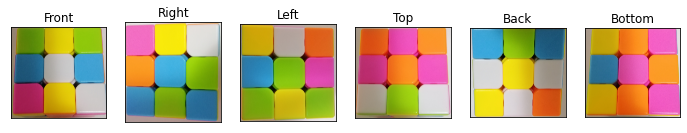

In [50]:
fig, ax = plt.subplots(1, 6, figsize=(12, 5))

rubik2 = {'front': front2, 'back': back2, 'top': top2, 'bottom': bot2,
          'right': right2, 'left': left2}
ax[0].imshow(front2)
ax[0].set_title('Front'), ax[0].set_xticks([]), ax[0].set_yticks([])
ax[1].imshow(right2)
ax[1].set_title('Right'), ax[1].set_xticks([]), ax[1].set_yticks([])
ax[2].imshow(left2)
ax[2].set_title('Left'), ax[2].set_xticks([]), ax[2].set_yticks([])
ax[3].imshow(top2)
ax[3].set_title('Top'), ax[3].set_xticks([]), ax[3].set_yticks([])
ax[4].imshow(back2)
ax[4].set_title('Back'), ax[4].set_xticks([]), ax[4].set_yticks([])
ax[5].imshow(bot2)
ax[5].set_title('Bottom'), ax[5].set_xticks([]), ax[5].set_yticks([]);

# Detect Cube and Crop

In [6]:
def multi_dil(im, num, selem=None):
    for i in range(num):
        im = dilation(im, selem=selem)
    return im


def multi_ero(im, num, selem=None):
    for i in range(num):
        im = erosion(im, selem=selem)
    return im


def edge_detection(img):
    # Convert image to grayscale
    img_bw = rgb2gray(img)
    img_bw = img_bw > 0.1
    # Blur image
    img_blur = filters.gaussian(img_bw, sigma=1)
    img_edge = feature.canny(img_bw, sigma=1)
    return img_edge


def crop_image(img):
    edge = edge_detection(img)

    pts = np.argwhere(edge > 0)

    y1, x1 = pts.min(axis=0)
    y2, x2 = pts.max(axis=0)

    height = y2 - y1
    width = x2 - x1

    return img[y1:y1 + height, x1: x1 + width]

## Rubik 1

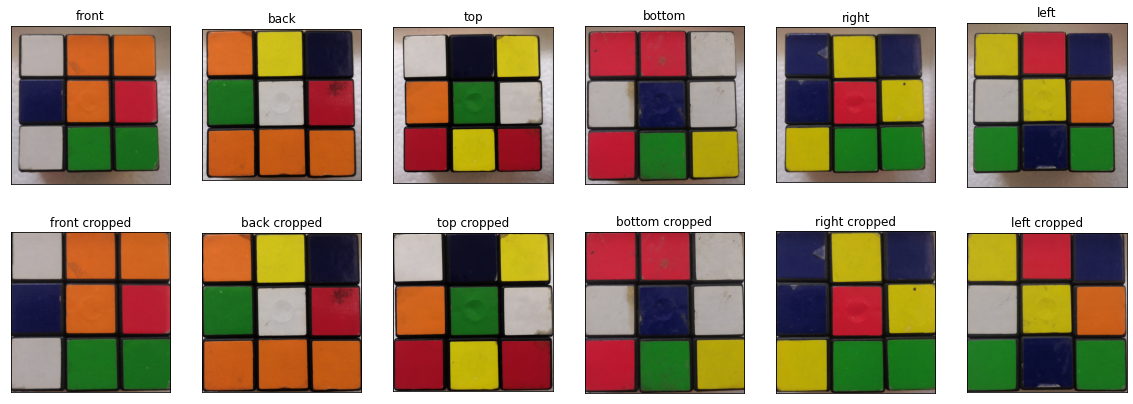

In [22]:
fig = plt.figure(figsize=(20, 7))
gs = gridspec.GridSpec(2, 6)

rubik1 = {} 
for idx, im in enumerate(zip(['front', 'back', 'top', 'bottom',
                               'right', 'left'],
                              [front1, back1, top1, bot1, right1, left1])):
    ax0 = fig.add_subplot(gs[idx])
    ax1 = fig.add_subplot(gs[idx+6])
    
    name = im[0]
    img = im[1]
    ax0.imshow(img)
    ax0.set_title(name)
    ax0.set_xticks([])
    ax0.set_yticks([])
    
    img_crop = crop_image(img)
    ax1.imshow(img_crop)
    ax1.set_title(name + ' cropped')
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    rubik1[name] = img_crop

# Detect Color

In [8]:
color_map = {
    'white': 1,
    'orange': 2,
    'green': 3,
    'blue': 4,
    'red': 5,
    'yellow': 6
}

In [9]:
def assign_blk_colors(img, colors):
    """Create a matrix with assigned block colors"""
    temp2 = np.zeros(img.shape[:-1])
    y, x = temp2.shape[0], temp2.shape[1]
    blk_height = y // 3
    blk_width = x // 3
    for col in range(3):
        for row in range(3):
            x1 = col * blk_width
            y1 = row * blk_height
            x2 = x1 + blk_width
            y2 = y1 + blk_height
            color = color_map[colors.pop(0)]
            temp2[y1:y2, x1:x2] = color
    return temp2


def create_dastaset(img, colors):
    """Compute RG chromaticity to serve as feature and stack labeled colors"""
    r = img[:, :, 0] * 1.0 / img.sum(axis=2)
    g = img[:, :, 1] * 1.0 / img.sum(axis=2)
    r[np.isnan(r)] = 0
    g[np.isnan(g)] = 0
    r_flat = np.expand_dims(r.flatten(), axis=1)
    g_flat = np.expand_dims(g.flatten(), axis=1)
    
    if colors:
        label = assign_blk_colors(img, colors)
        label_flat = np.expand_dims(label.flatten(), axis=1)
        return np.hstack((r_flat, g_flat, label_flat))
    else:
        return np.hstack((r_flat, g_flat))

## Rubik 1 Color

In [23]:
# Get the front side dataset
front1_img = rubik1['front']
front1_colors = ['white', 'orange', 'orange',
                 'blue', 'orange', 'red',
                 'white', 'green', 'green']
# front1_ds = create_dastaset(front1_img, front1_colors)
front1_ds = create_dastaset(front1_img, None)

# Get the back side dataset
back1_img = rubik1['back']
back1_colors = ['orange', 'yellow', 'blue',
                'green', 'white', 'red',
                'orange', 'orange', 'orange']
# back1_ds = create_dastaset(back1_img, back1_colors)
back1_ds = create_dastaset(back1_img, None)

# Get the top side dataset
top1_img = rubik1['top']
top1_colors = ['white', 'blue', 'yellow',
               'orange', 'green', 'white',
               'red', 'yellow', 'red']
# top1_ds = create_dastaset(top1_img, top1_colors)
top1_ds = create_dastaset(top1_img, None)


# Get the bottom side dataset
bot1_img = rubik1['bottom']
bot1_colors = ['red', 'red', 'white',
               'white', 'blue', 'white',
               'red', 'green', 'yellow']
# bot1_ds = create_dastaset(bot1_img, bot1_colors)
bot1_ds = create_dastaset(bot1_img, None)

# Get the left side dataset
left1_img = rubik1['left']
left1_colors = ['yellow', 'red', 'blue',
                'white', 'yellow', 'orange',
                'green', 'blue', 'green']
# left1_ds = create_dastaset(left1_img, left1_colors)
left1_ds = create_dastaset(left1_img, None)

# Get the right side dataset
right1_img = rubik1['right']
right1_colors = ['blue', 'yellow', 'blue',
                 'blue', 'red', 'yellow',
                 'yellow', 'green', 'green']
# right1_ds = create_dastaset(right1_img, right1_colors)
right1_ds = create_dastaset(right1_img, None)


rubik1_ds = np.vstack((front1_ds, back1_ds, top1_ds, bot1_ds,
                       left1_ds, right1_ds))
rubik1_ds = np.ma.masked_equal(rubik1_ds, 0)
warnings.filterwarnings('ignore')

## Rubik 2 Color

In [51]:
# Get the front side dataset
front2_img = rubik2['front']
front2_colors = ['green', 'yellow', 'green',
                 'blue', 'white', 'blue',
                 'red', 'yellow', 'white']
# front2_ds = create_dastaset(front2_img, front2_colors)
front2_ds = create_dastaset(front2_img, None)


# Get the back side dataset
back2_img = rubik2['back']
back2_colors = ['blue', 'green', 'blue',
                'white', 'yellow', 'white',
                'yellow', 'white', 'orange']
# back2_ds = create_dastaset(back2_img, back2_colors)
back2_ds = create_dastaset(back2_img, None)


# Get the top side dataset
top2_img = rubik2['top']
top2_colors = ['orange', 'red', 'orange',
               'red', 'orange', 'red',
               'white', 'green', 'white']
# top2_ds = create_dastaset(top2_img, top2_colors)
top2_ds = create_dastaset(top2_img, None)


# Get the bottom side dataset
bot2_img = rubik2['bottom']
bot2_colors = ['yellow', 'orange', 'red',
               'blue', 'red', 'orange',
               'yellow', 'orange', 'red']
# bot2_ds = create_dastaset(bot2_img, bot2_colors)
bot2_ds = create_dastaset(bot2_img, None)


# Get the left side dataset
left2_img = rubik2['left']
left2_colors = ['yellow', 'white', 'orange',
                'blue', 'green', 'red',
                'green', 'yellow', 'green']
# left2_ds = create_dastaset(left2_img, left2_colors)
left2_ds = create_dastaset(left2_img, None)


# Get the right side dataset
right2_img = rubik2['right']
right2_colors = ['red', 'yellow', 'white',
                 'orange', 'blue', 'green',
                 'blue', 'green', 'blue']
# right2_ds = create_dastaset(right2_img, right2_colors)
right2_ds = create_dastaset(right2_img, None)



rubik2_ds = np.vstack((front2_ds, back2_ds, top2_ds, bot2_ds,
                       left2_ds, right2_ds))
warnings.filterwarnings('ignore')

## Combine Both Rubriks

In [12]:
ds = np.vstack((rubik1_ds, rubik2_ds))
ds = np.ma.masked_equal(ds,0)

In [13]:
(ds==0).any()

False

In [52]:
# X = ds[:, :-1]
# y = to_categorical(ds[:, -1])

# Cluster RG values

In [15]:
kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(rubik1_ds)

KMeans(n_clusters=6, random_state=0)

In [16]:
rubik1_ds_clusters = kmeans.predict(rubik1_ds)

In [17]:
np.bincount(rubik1_ds_clusters)

array([2537397, 2204747, 2316535, 2484678, 5524547, 2428923], dtype=int64)

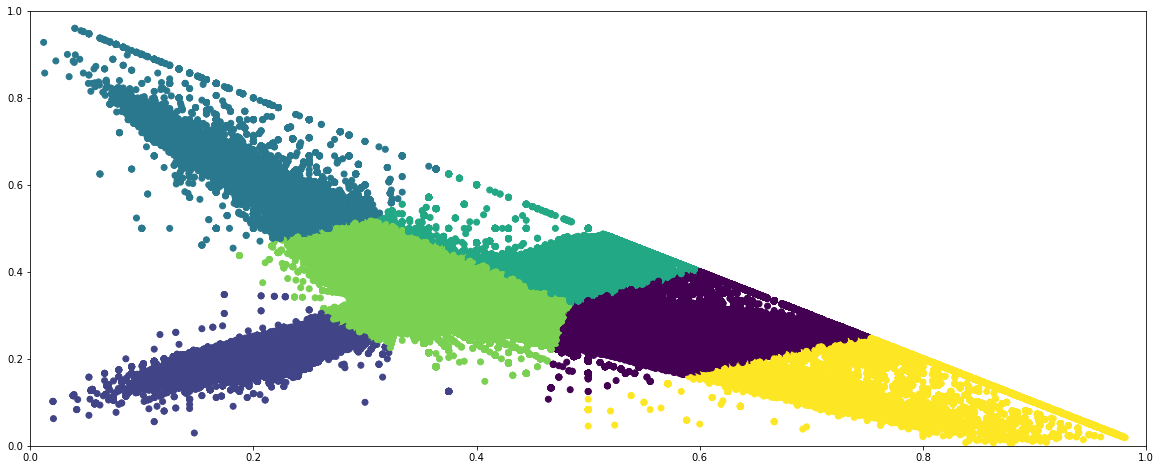

In [18]:
plt.figure(figsize=(20, 8))
plt.scatter(rubik1_ds[:, 0], rubik1_ds[:, 1], c=rubik1_ds_clusters)
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show();

In [47]:
kmeans_path = 'kmeans.pkl'
pickle.dump(kmeans, open(kmeans_path, 'wb'))
kmeans = pickle.load(open(kmeans_path, 'rb'))

# Revert Cluster Prediction

In [44]:
color_map = {
    1: 'orange',
    2: 'blue',
    3: 'green',
    4: 'yellow',
    5: 'white',
    6: 'red'
}

In [20]:
def get_rubrik_color(img):
    idx = 1
    y, x = img.shape[0], img.shape[1]
    blk_height = y // 3
    blk_width = x // 3
    block = {1: None, 2: None, 3: None,
             4: None, 5: None, 6: None,
             7: None, 8: None, 9: None}
    for col in range(3):
        for row in range(3):
            x1 = col * blk_width
            y1 = row * blk_height
            x2 = x1 + blk_width
            y2 = y1 + blk_height

            # Get RG chromaticity of block
            r = img[:, :, 0] * 1.0 / img.sum(axis=2)
            g = img[:, :, 1] * 1.0 / img.sum(axis=2)
            # Get block
            r = r[y1:y2, x1:x2]
            g = g[y1:y2, x1:x2]
            r_flat = np.expand_dims(r.flatten(), axis=1)
            g_flat = np.expand_dims(g.flatten(), axis=1)
            rg = np.hstack((r_flat, g_flat))
            rg[np.isnan(rg)] = 0
            rg = np.ma.masked_equal(rg, 0)
            # Determine the color based on cluster
            color_pred = kmeans.predict(rg)
            # Get the maximum count of color prediction
            color_max = np.argmax(np.bincount(color_pred)) + 1
            block[idx] = color_map[color_max]
            idx += 1
    return np.array(list(block.values())).reshape(3, 3).T

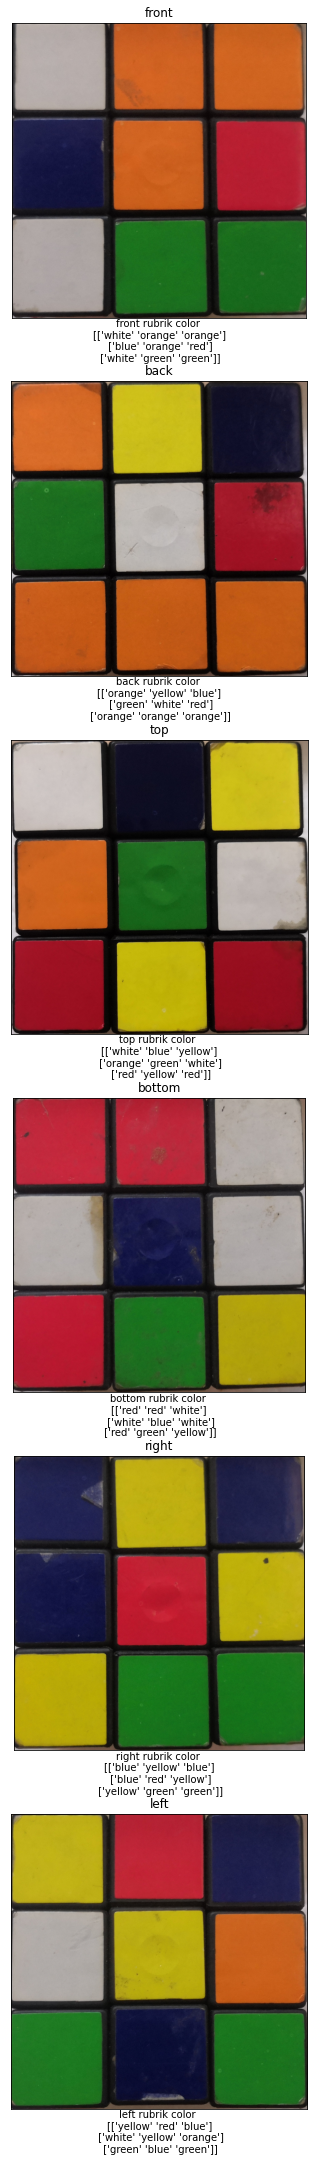

In [48]:
fig = plt.figure(figsize=(8, 30))
gs = gridspec.GridSpec(6, 1)
i = 0
faces = {}
for name, img in rubik1.items():
    ax = fig.add_subplot(gs[i])
    color = get_rubrik_color(img)
    faces[name] = color
    ax.imshow(img)
    ax.set_title(f'{name}')
    ax.set_xticks([])
    ax.set_yticks([])
#     print(f'{name} rubrik color \n', color)
    ax.text(0.5, -0.15, f'{name} rubrik color \n{color}', ha="center",
            transform=ax.transAxes)
    i += 1
plt.tight_layout()

# Solve Cube

In [42]:
def verify_cube_string_is_valid(cube_string):
    count = {"G": 0, "B": 0, "R": 0, "Y": 0, "W": 0, "O": 0}

    for c in cube_string:
        count[c] += 1

    for k in count:
        if count[k] != 9:
            raise Exception(f"Invalid cube string: {cube_string}")

    return cube_string


def generate_cube_string(faces):
    cube_string = ''

    def get_color_initial(color, mod=False):
        first_letter = color[0].upper()
        if mod:
            if 'O':
                first_letter = 'Y'
            elif 'Y':
                first_letter = 'O'
        return first_letter

    face = faces['top']
    for i in range(3):
        for j in range(3):
            first_letter = get_color_initial(face[i][j])
            cube_string += first_letter

    order = ['left', 'front', 'right', 'back']
    for i in range(3):
        for o in order:
            face = faces[o]
            for j in range(3):
                first_letter = get_color_initial(face[i][j])
                cube_string += first_letter

    face = faces['bottom']
    for i in range(3):
        for j in range(3):
            first_letter = get_color_initial(face[i][j])
            cube_string += first_letter

    return verify_cube_string_is_valid(cube_string)


def solve_cube(cube):
    c = Cube(cube)
    print(f"Cube: \n{c}\n\n")
    solver = Solver(c)
    solver.solve()
    return solver.moves

In [43]:
cube = generate_cube_string(faces)
print(f"Solution: \n\n{solve_cube(cube)}\n")

Cube: 
    WBG
    ORW
    YGY
GYB WOO BGB OGB
WGO BOY BYG RWY
RBR WRR GRR OOO
    YYW
    WBW
    YRG


Solution: 

['Ui', 'Ui', 'B', 'U', 'U', 'L', 'L', 'Di', 'B', 'D', 'Ei', 'R', 'E', 'Ri', 'Z', 'U', 'B', 'Ui', 'L', 'L', 'Di', 'B', 'D', 'R', 'R', 'Zi', 'B', 'B', 'B', 'Ri', 'B', 'B', 'R', 'Bi', 'Bi', 'D', 'Bi', 'Di', 'Z', 'U', 'U', 'Ui', 'Ui', 'Ui', 'B', 'U', 'B', 'B', 'B', 'B', 'D', 'Bi', 'Di', 'Z', 'D', 'B', 'Di', 'B', 'B', 'B', 'B', 'D', 'Bi', 'Di', 'Z', 'Bi', 'Ri', 'B', 'R', 'Z', 'Z', 'Z', 'B', 'L', 'Bi', 'Li', 'Bi', 'Di', 'B', 'D', 'Zi', 'Zi', 'B', 'B', 'B', 'Bi', 'Di', 'B', 'D', 'B', 'L', 'Bi', 'Li', 'Z', 'B', 'Bi', 'Di', 'B', 'D', 'B', 'L', 'Bi', 'Li', 'Z', 'B', 'L', 'Bi', 'Li', 'Bi', 'Di', 'B', 'D', 'Z', 'B', 'L', 'Bi', 'Li', 'Bi', 'Di', 'B', 'D', 'B', 'Bi', 'Di', 'B', 'D', 'B', 'L', 'Bi', 'Li', 'Z', 'X', 'X', 'D', 'F', 'R', 'Fi', 'Ri', 'Di', 'F', 'D', 'R', 'F', 'Ri', 'Fi', 'Di', 'Xi', 'Xi', 'X', 'X', 'Li', 'Fi', 'L', 'D', 'F', 'Di', 'Li', 'F', 'L', 'F', 'F', 'Zi', 'Li', 'Fi'

# Cluster 2

In [94]:
kmeans2 = KMeans(n_clusters=6, random_state=0)
kmeans2.fit(ds)

KeyboardInterrupt: 

In [ ]:
ds_clusters = kmeans.predict(ds)

In [ ]:
np.bincount(ds_clusters)

In [ ]:
plt.figure(figsize=(20, 8))
plt.scatter(ds[:, 0], ds[:, 1], c=ds_clusters)
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show();

# Train SVC Classifier to predict colors

df_train, df_test = pd.DataFrame(), pd.DataFrame()

for seed in range(20):
    for 
X_train, X_test, y_train, y_test = train_test_split(ds[:, :-1],
                                                    ds[:, -1],
                                                    test_size=0.15,
                                                    random_state=2021)

In [ ]:
model = Sequential(
    [
        Dense(7, activation='relu', name='layer1'),
        Dense(14, activation='relu', name='layer2'),
        Dense(7, activation='softmax', name='output_layer')
    ]
)
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint('best.h5', monitor='val_accuracy',
                             save_best_only=True)
early = EarlyStopping(monitor='val_accuracy', patience=10)
rp = ReduceLROnPlateau(monitor='val_accuracy', factor=0.7, patience=10,
                       cooldown=2)
batch_size = 500
steps = (X.shape[0] * 0.85) // batch_size
val_steps = (X.shape[0] * 0.15) // batch_size

In [ ]:
model.fit(X, y, epochs=200, batch_size=batch_size, validation_split=0.15,
          callbacks=[checkpoint, early, rp])

In [ ]:
parameters = {'kernel':['rbf'], 'gamma':[0.1, 1, 10], 'C':[0.1, 1, 10]}
svc = SVC()
clf = GridSearchCV(svc, parameters, n_jobs=4, verbose=1)
clf.fit(ds[:, :-1], ds[:, -1])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(ds[:, :-1],
                                                    ds[:, -1],
                                                    test_size=0.25,
                                                    random_state=2021)

In [ ]:
svc = SVC(kernel='rbf', gamma=1, C=1)
svc.fit(X_train, y_train)

# Predict Colors using SVC Classifier